### Lab: Q-Learning to Solve the Cliff Walk Problem

### University of Virginia
### Reinforcement Learning
#### Last updated: May 26, 2025

---

#### Instructions:

In Sutton & Barto (Section 6.5), the Cliff Walking problem is presented. You will apply Q-learning to teach an agent to solve it.  

Consider the grid below, where an agent begins in starting state S and wishes to reach goal state G by walking on a path and keeping off The Cliff (the gray region).  At each time step, the agent can potentially take one step left, right, up, or down. There is no discounting.  It is not possible for the agent to move off the grid. If the agent visits The Cliff, it incurs reward -100 and is immediately sent back to the start. The reward is -1 on all transitions apart from The Cliff. This incentivizes the agent to reach G as quickly as possible.

**Note**: Do not use libraries from `networkx`, `gym`, `gymnasium` when solving this problem.

---

<img src="./cliff_walk.png">  

#### TOTAL POINTS: 12

---

#### 1) Clearly explain how you will set up the state space and action space.
**(POINTS: 2)**

### **State Space**

The state space consists of a 4 × 12 grid, providing 48 discrete state.  
Each state is represented as a row–column tuple $(r, c)$.  
For example, the starting position is $(3, 0)$ and the goal state **G** is at $(3, 11)$.  
The cliff region occupies cells $(3, 1)$ through $(3, 10)$.

For this implementation, I will flatten each $(r, c)$ pair into a single integer index using the formula:

$$
\text{index} = r \times 12 + c
$$

This yields state indices ranging from 0 to 47, with the start state corresponding to index 36.

---

### **Action Space**

The action space consists of four discrete actions available in each state: **Up**, **Right**, **Down**, and **Left**.  
If an action would move the agent off the grid, the agent remains in the same state.

| Action | Code | Δrow | Δcol | Description |
|:-------|:-----:|:----:|:----:|:-------------|
| Up     | 0 | −1 | 0 | Move one cell up |
| Right  | 1 | 0 | +1 | Move one cell right |
| Down   | 2 | +1 | 0 | Move one cell down |
| Left   | 3 | 0 | −1 | Move one cell left |

If the agent steps into the cliff region, it receives a reward of −100 and is reset to the start at $(3, 0)$, which corresponds to index 36. The episode ends.


The following shows the state space defined by the grid indexes.

In [ ]:
import numpy as np
grid = np.arange(48).reshape(4, 12)
grid


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]])

#### 2) Write a Q-learning algorithm that helps the agent learn a policy to reach the goal  
**(POINTS: 8)**.

Use $\epsilon$-greedy action selection with $\epsilon=0.1$.  
You can decide the other parameters as you wish.  

In [208]:
import numpy as np
SEED = 1
rng  = np.random.default_rng(SEED)

In [209]:
#define the state space
N_ROWS, N_COLS = 4, 12
START = (3,0)
GOAL  = (3,11)
CLIFF = [(3, col) for col in range(1, 11)]

In [210]:
#define the action space
ACTION_NAMES = ['UP', 'RIGHT', 'DOWN', 'LEFT']
ACTIONS = [(-1, 0), (0,1), (1, 0), (0, -1)]
N_ACTIONS = len(ACTIONS)

In [264]:
#set up conversion for tuple to index

def s2i(s):
  r, c = s
  return r * N_COLS + c

def i2s(i):
  r = i // N_COLS
  c = i % N_COLS
  return (r, c)

N_STATES = N_ROWS * N_COLS
START_INDEX = s2i(START)
GOAL_INDEX = s2i(GOAL)

In [237]:
def is_valid_state(r,c):
  return 0 <= r < N_ROWS and 0 <= c < N_COLS

def step(state_index, action):
  """
  returns the next state, reward, and done flag
  """
  #terminal state
  if state_index == GOAL_INDEX:
    reward = 0.0
    done = True
    ns_index = GOAL_INDEX
    return ns_index, reward, done

  r, c = i2s(state_index)
  dr, dc = ACTIONS[action]
  new_r, new_c = r + dr, c + dc

  #if off grid - stay in place
  if not is_valid_state(new_r, new_c):
    new_r, new_c = r, c

  #if cliff - reset and end episode
  if (new_r, new_c) in CLIFF:
    reward = -100.0
    done = True
    cliff_index = s2i((new_r, new_c)) # return where the agent when episode ends
    return cliff_index, reward, done

  #valid move
  ns_index = s2i((new_r, new_c))
  reward = -1.0
  done = (ns_index == GOAL_INDEX)
  return ns_index, reward, done


In [213]:
#define the e greedy policy

def act(Q_row, epsilon = 0.1):
  if rng.random() <= epsilon:
    return rng.integers(N_ACTIONS)

  #break ties randomly
  max_val = np.max(Q_row)
  candidates = np.flatnonzero(Q_row == max_val)
  return int(rng.choice(candidates))


In [274]:
#quick test to check egreedy
Q_row = np.array([0.5, 0.5, 0.2, 0.1])
for _ in range(5):
    print(act(Q_row, epsilon=0.1))


0
1
0
0
1


In [251]:
episodes = 8000
alpha = 0.5
gamma = 1.0
epsilon = 0.1

In [252]:
def q_learning (episodes, alpha, gamma, epsilon):
  Q = np.zeros((N_STATES, N_ACTIONS), dtype=np.float32)
  returns = [] # sum of rewards per episode
  final_states = []

  for episode in range(1, episodes + 1):
    state_index = START_INDEX
    done = False
    episode_reward = 0.0

    while not done:

      action = act(Q[state_index], epsilon) #selection action
      next_state_index, reward, done = step(state_index, action) #take a step

      target = reward + (0.0 if done else gamma * np.max(Q[next_state_index]))

      Q[state_index, action] += alpha * (target - Q[state_index, action])

      state_index = next_state_index
      episode_reward += reward #accumulate total reward for episode

    #at end of episode, update total rewards and record final state
    returns.append(episode_reward)
    final_states.append(state_index)

  return Q, np.array(returns), np.array(final_states)



In [253]:
#Extract the policy based on argmax
Q, ep_returns, ep_final_states = q_learning(episodes, alpha, gamma, epsilon)
policy = np.argmax(Q, axis=1).reshape(N_ROWS, N_COLS)

In [254]:
policy

array([[3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

**Note to grader for partial credit:**  
Student answers in parts 3-5 should help understand if the algorithm is implemented correctly.  


In [276]:
#Helpful code to render the policy using arrows for readability
ARROWS = np.array(["↑","→","↓","←"])
def render_policy(policy):
    rows=[]
    for r in range(N_ROWS):
        cells=[]
        for c in range(N_COLS):
            if (r,c)==START: cells.append("S")
            elif (r,c)==GOAL: cells.append("G")
            elif (r,c) in CLIFF: cells.append("■")
            else: cells.append(ARROWS[policy[r,c]])
        rows.append(" ".join(cells))
    return "\n".join(rows)

In [277]:
print(render_policy(policy))

← → ↓ → → → → → → → ↓ ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
S ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ G


#### 3) After training the policy, print the row from the Q-table representing the starting state  

In [278]:
# After training
for a, val in zip(ACTION_NAMES, Q[START_INDEX]):
    print(f"{str(a):>10}: {val:8.3f}")

        UP:  -13.000
     RIGHT: -100.000
      DOWN:  -14.000
      LEFT:  -14.000


#### 4) Based on training results, create a plot that shows final state of each episode on the y-axis, and the episode number on the x-axis

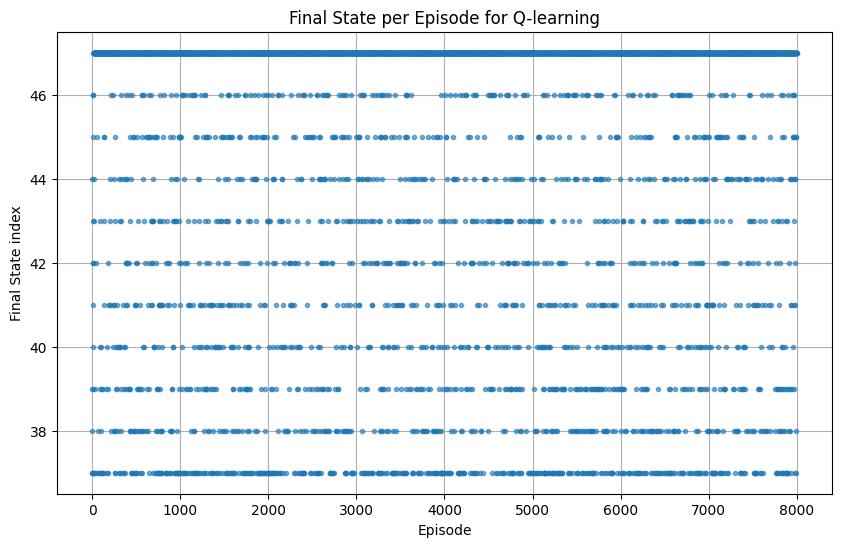

In [279]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ep_final_states, marker='.', linestyle='None', alpha=0.6)
plt.xlabel("Episode")
plt.ylabel("Final State index")
plt.title("Final State per Episode for Q-learning")
plt.grid(True)
plt.show()


#### 5) Given the learned policy, run one episode

Show evidence that the agent has learned how to successfully complete the Cliff walk

In [280]:
def run_one_episode(policy):
    state_index = START_INDEX
    done = False
    total_reward = 0
    path = [i2s(state_index)]
    steps = 0

    while not done:
        r,c = i2s(state_index)
        action = policy[r,c]
        next_state_index, reward, done = step(state_index, action)
        path.append(i2s(next_state_index))
        state_index = next_state_index
        total_reward += reward
        steps += 1

    return path, total_reward, steps

In [288]:
path, G, steps = run_one_episode(policy)
print(f"Total Reward: {G}")
print(f"Steps: {steps}")
print(f"Path: {path}")

Total Reward: -13.0
Steps: 13
Path: [(3, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 11)]


In [283]:
print(render_policy(policy))

← → ↓ → → → → → → → ↓ ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
S ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ G


#### 6) Explain your results. Do they make sense?
**(POINTS: 2)**

**Note to grader for partial credit:** Grade based on the reasoning.

Yes, my results make sense. The total reward I calculated of -13 reflects the 13 steps the agent makes to reach the goal state moving along the cliff.  The path shows evidence of the agent moving along row 2 from column 0 to column 11 and then down. This can be seen in the rendering of the policy shown above.

After training, the Q values are logical at the starting state. Moving up is the optimal path and takes -13 rewards. If the agent moves right, it receives -100 penalty. If the agent moves left or down, it would go off the grid so it stays in place and incurs a -1 penalty, but would still need to take 13 steps to reach the goal from the starting state, so value of -14.

The scatter plot was a bit strange, but I believe it is accurate. What I see happening is that because of e-greedy, the agent is still i exploring in later episodes after reaching the goal state in early episodes. This causes the agent to enter the cliff even during later episodes.

I believe that after 8000 episodes, the algorithm has converged. When running the one_episode function multiple times, it produces the same results consistently.